In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import gc; gc.enable()
from sklearn import preprocessing, linear_model, metrics
import matplotlib.pyplot as plt

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

holidays_events.csv
items.csv
oil.csv
sample_submission.csv
stores.csv
test.csv
train.csv
transactions.csv



In [2]:
dtypes = {'id':'int64', 'item_nbr':'int32', 'store_nbr':'int8', 'onpromotion':str}
data = {
    'tra': pd.read_csv('../input/train.csv', dtype=dtypes, parse_dates=['date']),
    'tes': pd.read_csv('../input/test.csv', dtype=dtypes, parse_dates=['date']),
    'ite': pd.read_csv('../input/items.csv'),
    'sto': pd.read_csv('../input/stores.csv'),
    'trn': pd.read_csv('../input/transactions.csv', parse_dates=['date']),
    'hol': pd.read_csv('../input/holidays_events.csv', dtype={'transferred':str}, parse_dates=['date']),
    'oil': pd.read_csv('../input/oil.csv', parse_dates=['date']),
    }

In [3]:
train = data['tra']#[(data['tra']['date'].dt.month == 8) & (data['tra']['date'].dt.day > 15)]
test = data['tes']#[(data['tes']['date'].dt.month == 8) & (data['test']['date'].dt.day > 15)]

In [4]:
train["item_nbr"].value_counts(sort = True,ascending=False).nlargest(5)

502331    83475
314384    83450
364606    83308
265559    83047
559870    82513
Name: item_nbr, dtype: int64

In [5]:
strain_502331= train[(train["item_nbr"] == 502331)]
stest_502331= test[(test["item_nbr"] == 502331)]

In [6]:
strain = strain_502331
stest = stest_502331
print(strain.shape,stest.shape)

(83475, 6) (864, 5)


In [7]:
target = strain['unit_sales'].values
target[target < 0.] = 0.
strain['unit_sales'] = target

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [8]:
strain = pd.merge(strain, data['ite'], how='left', on=['item_nbr'])
strain = pd.merge(strain, data['sto'], how='left', on=['store_nbr'])
data_h_1 = data['hol'][data['hol']['locale'] == 'National'][['date','transferred']]
data_h_1['transferred'] = data_h_1['transferred'].map({'False': 0, 'True': 1})
strain = pd.merge(strain, data_h_1, how='left', on=['date'])
strain = pd.merge(strain, data['oil'], how='left', on=['date'])

stest = pd.merge(stest, data['ite'], how='left', on=['item_nbr'])
stest = pd.merge(stest, data['sto'], how='left', on=['store_nbr'])
data_h_t = data['hol'][data['hol']['locale'] == 'National'][['date','transferred']]
data_h_t['transferred'] = data_h_t['transferred'].map({'False': 0, 'True': 1})
stest = pd.merge(stest, data_h_t, how='left', on=['date'])
stest = pd.merge(stest, data['oil'], how='left', on=['date'])

In [9]:
from sklearn import preprocessing
def df_transform(df):
    df['date'] = pd.to_datetime(df['date'])
    df['yea'] = df['date'].dt.year
    df['mon'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['dayofweek'] = df['date'].dt.dayofweek
    df['onpromotion'] = df['onpromotion'].map({'False': 1, 'True': 2})
    df['perishable'] = df['perishable'].map({0:1.0, 1:1.25})
    df = df.fillna(0)
    return df
def df_lbl_enc(df):
    for c in df.columns:
        if df[c].dtype == 'object':
            lbl = preprocessing.LabelEncoder()
            df[c] = lbl.fit_transform(df[c])
            print(c)
    return df


In [10]:
strain_t = df_transform(strain)
strain_t_e = df_lbl_enc(strain_t)

stest_t = df_transform(stest)
stest_t_e = df_lbl_enc(stest_t)

family
city
state
type
family
city
state
type


In [11]:
strain_t_e_dateIndex = strain_t_e.set_index('date')
stest_t_e_dateIndex = stest_t_e.set_index('date')

col =[c for c in strain_t_e_dateIndex if c not in ['id','item_nbr','mon','class','city','cluster','unit_sales']]
train_features = strain_t_e_dateIndex[col]
target = np.log1p(strain_t_e_dateIndex[['unit_sales']])

col =[c for c in stest_t_e_dateIndex if c not in ['id','item_nbr','mon','class','city','cluster']]
features = stest_t_e_dateIndex[col]

In [12]:
from sklearn.model_selection import train_test_split

X_train = train_features['2013':'2016']
X_test = train_features['2017']
y_train = target['2013':'2016']
y_test = target['2017']

#X_train, X_test, y_train, y_test = train_test_split(train_features, target, test_size=0.20, random_state=42)

In [13]:
W_train = X_train['perishable']#.map({0:1.0, 1:1.25})
W_test = X_test['perishable']#.map({0:1.0, 1:1.25})
#W_train = W_train.fillna(0)
#W_test = W_test.fillna(0)

In [14]:
from sklearn import metrics
def NWRMSLE(y, pred, w):
    return metrics.mean_squared_error(y, pred, sample_weight=w)**0.5

In [15]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import cross_validation

rf = RandomForestRegressor(max_features = "auto", min_samples_leaf = 50,n_estimators = 100,random_state =50,oob_score =True )

rf.fit(X_train, y_train)
print ('RF accuracy: TRAINING', rf.score(X_train,y_train,W_train))
print ('RF accuracy: TESTING', rf.score(X_test,y_test,W_test))
print("feature Importance",rf.feature_importances_)
yhat1 = rf.predict(X_test)
print('NWRMSLE RF',NWRMSLE((y_test),(yhat1),W_test.values ))

/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys


RF accuracy: TRAINING 0.771417463539
RF accuracy: TESTING 0.748201438787
feature Importance [ 0.51121207  0.00445504  0.          0.          0.1030354   0.16696161
  0.          0.01746875  0.04472853  0.01091761  0.14122098]
NWRMSLE RF 0.322782339177


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


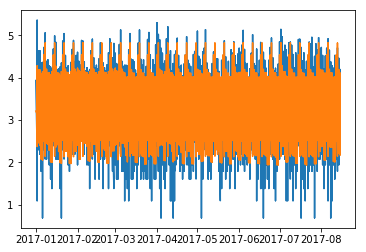

In [16]:
y_test['pred']=yhat1
plt.plot(y_test['unit_sales'])
plt.plot(y_test['pred'])
plt.show()